## Dataset Content

The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

    sex: female or male
    age: of the patient.
    classification: covid_df test findings. Values 1-3 mean that the patient was diagnosed with covid_df in different
    degrees. 4 or higher means that the patient is not a carrier of covid_df or that the test is inconclusive.
    patient type: hospitalized or not hospitalized.
    pneumonia: whether the patient already have air sacs inflammation or not.
    pregnancy: whether the patient is pregnant or not.
    diabetes: whether the patient has diabetes or not.
    copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
    asthma: whether the patient has asthma or not.
    inmsupr: whether the patient is immunosuppressed or not.
    hypertension: whether the patient has hypertension or not.
    cardiovascular: whether the patient has heart or blood vessels related disease.
    renal chronic: whether the patient has chronic renal disease or not.
    other disease: whether the patient has other disease or not.
    obesity: whether the patient is obese or not.
    tobacco: whether the patient is a tobacco user.
    usmr: Indicates whether the patient treated medical units of the first, second or third level.
    medical unit: type of institution of the National Health System that provided the care.
    intubed: whether the patient was connected to the ventilator.
    icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
    death: indicates whether the patient died or recovered.


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.neural_network import MLPClassifier
import shap

c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
covid_df = pd.read_csv("Covid Data.csv")

covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


## Data Preprocessing

In [3]:
#only keep covid_df positive patient data
covid_df = covid_df.loc[(covid_df.CLASIFFICATION_FINAL < 4)]
#Cleaning the data to keep only the rows containing 1, 2
covid_df = covid_df[(covid_df.PNEUMONIA == 1) | (covid_df.PNEUMONIA == 2)] #uses bitwise OR
covid_df = covid_df[(covid_df.DIABETES == 1) | (covid_df.DIABETES == 2)]
covid_df = covid_df[(covid_df.COPD == 1) | (covid_df.COPD == 2)]
covid_df = covid_df[(covid_df.ASTHMA == 1) | (covid_df.ASTHMA == 2)]
covid_df = covid_df[(covid_df.INMSUPR == 1) | (covid_df.INMSUPR == 2)]
covid_df = covid_df[(covid_df.HIPERTENSION == 1) | (covid_df.HIPERTENSION == 2)]
covid_df = covid_df[(covid_df.OTHER_DISEASE == 1) | (covid_df.OTHER_DISEASE == 2)]
covid_df = covid_df[(covid_df.CARDIOVASCULAR == 1) | (covid_df.CARDIOVASCULAR == 2)]
covid_df = covid_df[(covid_df.OBESITY == 1) | (covid_df.OBESITY == 2)]
covid_df = covid_df[(covid_df.RENAL_CHRONIC == 1) | (covid_df.RENAL_CHRONIC == 2)]
covid_df = covid_df[(covid_df.TOBACCO == 1) | (covid_df.TOBACCO == 2)]

covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
5,2,1,1,2,9999-99-99,2,1,40,2,2,...,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,...,2,2,2,2,2,2,2,2,3,97


In [4]:
#copy df to preserve death date info
visualization_df = covid_df.copy(deep=True)

#if death date given, mark it as 1, else 0
covid_df.DATE_DIED = covid_df.DATE_DIED.apply(lambda x: 0 if x == "9999-99-99" else 1) #ruins data visualization
#if data missing, mark it as a 0
covid_df.INTUBED = covid_df.INTUBED.apply(lambda x: x if x == 1 else 0)                   
covid_df.ICU = covid_df.ICU.apply(lambda x: x if x == 1 else 0)

covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,1,0,1,65,2,2,...,2,2,1,2,2,2,2,2,3,0
2,2,1,2,2,1,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,0
4,2,1,2,1,1,0,2,68,97,1,...,2,2,1,2,2,2,2,2,3,0
5,2,1,1,2,0,0,1,40,2,2,...,2,2,2,2,2,2,2,2,3,0
6,2,1,1,1,0,0,2,64,2,2,...,2,2,2,2,2,2,2,2,3,0


In [5]:
#create the at risk column
covid_df['HIGH_RISK'] = covid_df['DATE_DIED'] + covid_df['INTUBED'] + covid_df['ICU']
covid_df.HIGH_RISK = covid_df.HIGH_RISK.apply(lambda x: 1 if x > 0 else 0) 

#columns no longer useful bc: 
# all patients are now covid positive 
# the rest of the columns are repped by the at risk column now 
covid_df.drop(columns = ['CLASIFFICATION_FINAL', 'INTUBED', 'ICU', 'DATE_DIED'], inplace=True)

print(f"{100*(covid_df.HIGH_RISK.value_counts()[0]/len(covid_df.HIGH_RISK))}% of the data isn't high risk")

covid_df.head()

84.57639671053646% of the data isn't high risk


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,HIGH_RISK
0,2,1,1,1,1,65,2,2,2,2,2,1,2,2,2,2,2,1
2,2,1,2,2,2,55,97,1,2,2,2,2,2,2,2,2,2,1
4,2,1,2,1,2,68,97,1,2,2,2,1,2,2,2,2,2,1
5,2,1,1,2,1,40,2,2,2,2,2,2,2,2,2,2,2,0
6,2,1,1,1,2,64,2,2,2,2,2,2,2,2,2,2,2,0


In [6]:
print(covid_df.PREGNANT.value_counts())

#98 = female not pregnant, set to 2 for not pregnant
covid_df.PREGNANT = covid_df.PREGNANT.replace(98, 2)
#97 = men, set to 2 for not pregnant
covid_df.PREGNANT = covid_df.PREGNANT.replace(97, 2)

print(covid_df.PREGNANT.value_counts())

97    207594
2     177258
1       2744
98      1282
Name: PREGNANT, dtype: int64
2    386134
1      2744
Name: PREGNANT, dtype: int64


In [19]:
#drop targets from x and set them as y
X = covid_df.drop("HIGH_RISK", axis = 1)
Y = covid_df["HIGH_RISK"]

display(covid_df.head())

#split data into training and test
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0) #rand state so same rando shuffle
#create validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,HIGH_RISK
0,2,1,1,1,1,65,2,2,2,2,2,1,2,2,2,2,2,1
2,2,1,2,2,2,55,2,1,2,2,2,2,2,2,2,2,2,1
4,2,1,2,1,2,68,2,1,2,2,2,1,2,2,2,2,2,1
5,2,1,1,2,1,40,2,2,2,2,2,2,2,2,2,2,2,0
6,2,1,1,1,2,64,2,2,2,2,2,2,2,2,2,2,2,0


x_train shape: (217771, 17), y_train shape: (217771,)
x_val shape: (54443, 17), y_val shape: (54443,)
x_test shape: (116664, 17), y_test shape: (116664,)


## Data Visualization

In [8]:
#die date vars created 
visualization_df["MONTH"] = visualization_df.DATE_DIED.str.split("/", expand = True)[1]
visualization_df["YEAR"] = visualization_df.DATE_DIED.str.split("/", expand = True)[2]

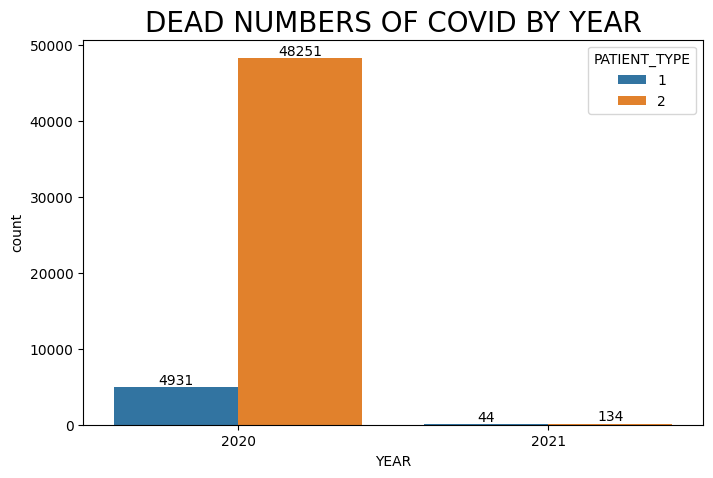

In [9]:
#count number of patients died each year by patient type (1=not hopitalized, 2=hospitalized)
plt.figure(figsize = (8,5))
ax = sns.countplot(x = "YEAR", hue = "PATIENT_TYPE", data = visualization_df)
plt.title("DEAD NUMBERS OF COVID BY YEAR", fontsize = 20)
for bars in ax.containers:
    ax.bar_label(bars)

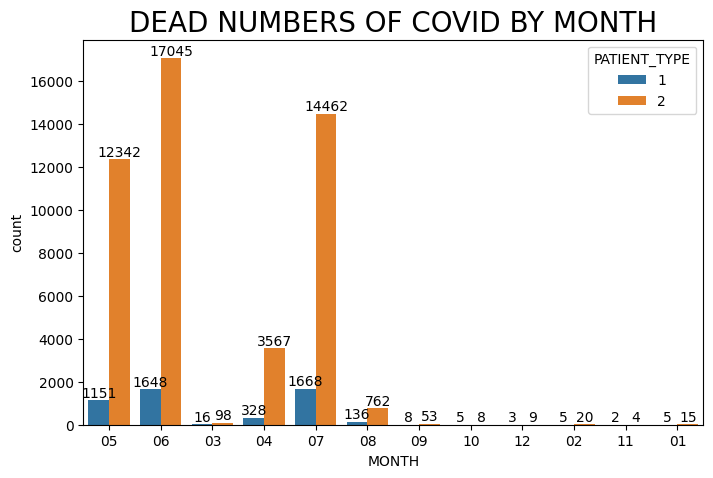

In [10]:
#months ppl most died in
plt.figure(figsize = (8,5))
ax = sns.countplot(x = "MONTH", hue = "PATIENT_TYPE", data = visualization_df)
plt.title("DEAD NUMBERS OF COVID BY MONTH", fontsize = 20)
for bars in ax.containers:
    ax.bar_label(bars)

## Model Classifier

### Restore Model

In [ ]:
model = tf.keras.models.load_model("saved_models/" + "")

model.summary(expand_nested=True, show_trainable=True)

filename = ""

In [ ]:
layers = [(100,50,30,10,5), (15,10,5,10,15), (20,20,20,20), (10)]
optimizers = ['adam', 'sgd']
mlp_accuracy = {}
mlp_best_result = 0

for (i, opt) in  enumerate(optimizers):
    mlp_accuracy[i] = np.zeros(len(layers))
    for (j, layer) in enumerate(layers):
        # create a Logistic Regression classifier instance and compute the prediction
        mlp_classifier = MLPClassifier(hidden_layer_sizes = layer,
                                          solver = opt,
                                          learning_rate ='adaptive',
                                          max_iter = 500)
        mlp_classifier.fit(x_train, y_train)
        y_pred = mlp_classifier.predict(x_val)

        # calculate accuracy and save best model
        mlp_accuracy[i][j] = accuracy_score(y_pred, y_val)
        if mlp_accuracy[i][j] > mlp_best_result:
            mlp_best_result = mlp_accuracy[i][j]
            mlp_best_model = mlp_classifier

params = mlp_best_model.get_params()
print('best result for: optimizer = %s, layer = %s, Accuracy = %f' % (params['solver'], params['hidden_layer_sizes'], mlp_best_result))

### Create Model

In [ ]:
filename = "Custom_fcn15_10_5_10_15"

input = tf.keras.layers.Input(x_train.shape[1])
x = tf.keras.layers.Dense(
    units=15,
    activation="relu"
)(input)
x = tf.keras.layers.Dense(
    units=10,
    activation="relu"
)(x)
x = tf.keras.layers.Dense(
    units=5,
    activation="relu"
)(x)
x = tf.keras.layers.Dense(
    units=10,
    activation="relu"
)(x)
x = tf.keras.layers.Dense(
    units=15,
    activation="relu"
)(x)
preds = tf.keras.layers.Dense(
    units=1,
    activation=tf.keras.activations.sigmoid 
)(x)
model = tf.keras.Model(input, preds)

model.summary(expand_nested=True, show_trainable=True)


In [ ]:
def ones_f_score(y_true, pred):

  #Comps prediction of each object to its label
  truePositive = np.sum((pred + y_true) == 2) #pred=1, true=1
  trueNegative = np.sum((pred + y_true) == 0) #pred=0, true=0
  falsePositive = np.sum((y_true - pred) == -1) #pred=1, true=0
  falseNegative = np.sum((pred - y_true) == -1) #pred=0, true=1
  positive = np.count_nonzero(y_true == 1)
  negative = len(y_true)-positive
  
  #print(f"Competition accuracy is {(truePositive+trueNegative)/(truePositive+trueNegative+falseNegative+falsePositive)}")

  #Calcs F-measure
  accuracy = 100*np.sum(pred == y_true)/len(y_true)
  recall = truePositive / (truePositive + falseNegative)
  precision = truePositive / (truePositive + falsePositive)
  eval = 2*(precision * recall) / (precision + recall)
  return eval

model.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning_rate=lr_scheduler #RMSprop()
    loss=tf.keras.losses.BinaryCrossentropy(), #from_logits=True
    metrics=['accuracy', ones_f_score]
)

In [ ]:
logger_callback = tf.keras.callbacks.CSVLogger(
    filename="model_logs/" + filename + '.csv',
    separator=',',
    append=True #don't overwrite if file exists already
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", #"ones_f_score"
    min_delta=0.0001,
    patience=10,
    verbose=1,
    #restore_best_weights=True
)

history = model.fit(
    x_train, 
    y_train, 
    initial_epoch=101,
    epochs=200, 
    validation_data=(x_val, y_val), 
    shuffle=True, #shuffles data after every epoch to reduce overfitting
    callbacks=[logger_callback,], #tb_callback, checkpoint_callback, early_stopping_callback], 
    workers=4,
    use_multiprocessing = True,
)

In [13]:
# create a Logistic Regression classifier instance and compute the prediction
model = MLPClassifier(
        hidden_layer_sizes = (15, 10, 5, 10, 15),
        solver = 'adam',
        learning_rate ='adaptive',
        max_iter = 500,
        verbose=True
    )
model.fit(x_train, y_train)

Iteration 1, loss = 0.35310177
Iteration 2, loss = 0.21842959
Iteration 3, loss = 0.21631987
Iteration 4, loss = 0.21588695
Iteration 5, loss = 0.21541114
Iteration 6, loss = 0.21540022
Iteration 7, loss = 0.21486692
Iteration 8, loss = 0.21449168
Iteration 9, loss = 0.21437452
Iteration 10, loss = 0.21438638
Iteration 11, loss = 0.21426708
Iteration 12, loss = 0.21400904
Iteration 13, loss = 0.21409192
Iteration 14, loss = 0.21368410
Iteration 15, loss = 0.21377140
Iteration 16, loss = 0.21363970
Iteration 17, loss = 0.21368646
Iteration 18, loss = 0.21345927
Iteration 19, loss = 0.21359550
Iteration 20, loss = 0.21335503
Iteration 21, loss = 0.21323609
Iteration 22, loss = 0.21342906
Iteration 23, loss = 0.21316792
Iteration 24, loss = 0.21322245
Iteration 25, loss = 0.21332748
Iteration 26, loss = 0.21321187
Iteration 27, loss = 0.21304062
Iteration 28, loss = 0.21307019
Iteration 29, loss = 0.21280540
Iteration 30, loss = 0.21290947
Iteration 31, loss = 0.21279906
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(15, 10, 5, 10, 15), learning_rate='adaptive',
              max_iter=500, verbose=True)

## Results Metrics

In [30]:
from sklearn.metrics import classification_report, f1_score

yPred = np.round(model.predict(x_test)).flatten()
print(yPred.shape)
print(f"Model test accuracy = {accuracy_score(yPred, y_test)}")
print(ones_f_score(y_test, yPred))
#print(f1_score(y_test, yPred , average="macro"))
print('\n', classification_report(y_test, yPred)) #most lacking in macro avg, f1-score on 1's

3646/3646 [==============================] - 3s 836us/step
(116664,)
Model test accuracy = 0.8924861139683192
0.6669322074404525

               precision    recall  f1-score   support

           0       0.94      0.93      0.94     98591
           1       0.64      0.69      0.67     18073

    accuracy                           0.89    116664
   macro avg       0.79      0.81      0.80    116664
weighted avg       0.90      0.89      0.89    116664



## Training Plots

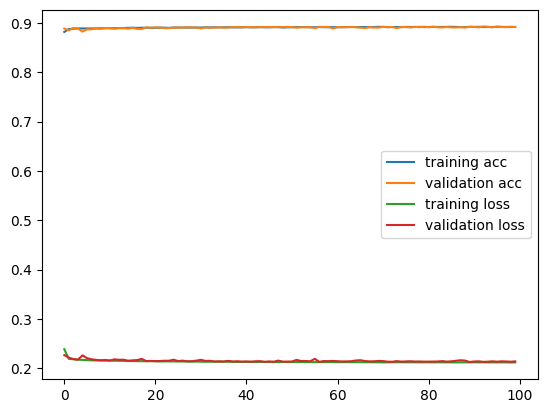

In [25]:
#history of training and validation accuracy (only works if model trained and not preloaded)
plt.plot(history.history['accuracy'], label='training acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
#plt.plot(history.history['ones_f_score'], label='Ones f score')
plt.legend()
plt.show()

## Feature Importance

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.KernelExplainer(model, shap.sample(x_test, 1))
shap_values = explainer.shap_values(x_test)

dfFeatureImportances = pd.DataFrame(list(X), abs(shap_values[0][0,:]))
dfFeatureImportances.columns = ["Feature_Names"]
dfFeatureImportances["Importances"] = dfFeatureImportances.index
dfFeatureImportances = dfFeatureImportances.sort_values(by = "Importances", ascending = False)
dfFeatureImportances.index = np.arange(0,len(dfFeatureImportances))

dfFeatureImportances

## Save Model

In [23]:
model.save("saved_models/" + filename + "_89.2test_66.7f1") #trained for 100 epochs

INFO:tensorflow:Assets written to: saved_models/Custom_fcn15_10_5_10_15_89.2test_66.7f1\assets
